# Section 1: Obtain Feature Map of LeNet

In [1]:
import os
import json
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
root_dir = os.path.join(os.getcwd(), "..")
sys.path.append(root_dir)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, return_intermediate=False):
        # Convolutional layers
        x1 = F.relu(self.conv1(x))
        x1_pooled = F.max_pool2d(x1, (2, 2))
        x2 = F.relu(self.conv2(x1_pooled))
        x2_pooled = F.max_pool2d(x2, (2, 2))

        # Flattening the output for the fully connected layers
        #flattened = x2_pooled.view(-1, self.num_flat_features(x2_pooled))
        x = x2_pooled.view(-1, 16*5*5)
        # Fully connected layers
        x3 = F.relu(self.fc1(x))
        x4 = F.relu(self.fc2(x3))
        output = self.fc3(x4)

        if return_intermediate:
            return x1, x2, x3, x4, output
        else:
            return output

    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)


In [4]:
path = "../config/LeNet_config.json"
with open(path) as json_file:
    config = json.load(json_file)
config['data']['path'] = "../data"

In [5]:
model_save_path = config["model"]["save_path"]
model = LeNet()
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

print('Model read successfully from', model_save_path)

Model read successfully from ../models/LeNet.pth


In [6]:
def plot_feature_maps(feature_maps, title):
    fig, axes = plt.subplots(1, len(feature_maps),figsize=(15, 2))
    fig.suptitle(title)
    for i, fmap in enumerate(feature_maps):
        axes[i].imshow(fmap.detach().cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

In [7]:
from src.data.get_dataloader import get_dataloaders
train_dataloader, validation_dataloader, test_dataloader = get_dataloaders(config)

Creating dataloaders...
Dataloaders created


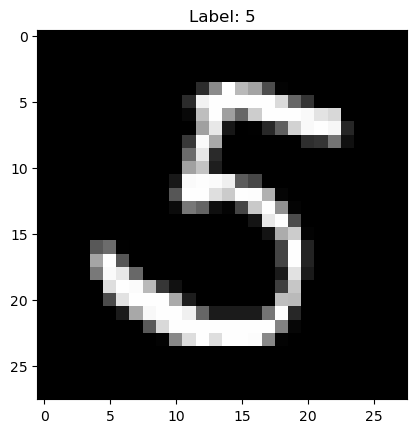

In [8]:
images, labels = next(iter(train_dataloader))
random_image = images[0]
random_label = labels[0]

plt.imshow(random_image.squeeze(), cmap='gray')
plt.title(f'Label: {random_label.item()}')
plt.show()

In [9]:
layers = model.forward(random_image,return_intermediate=True)

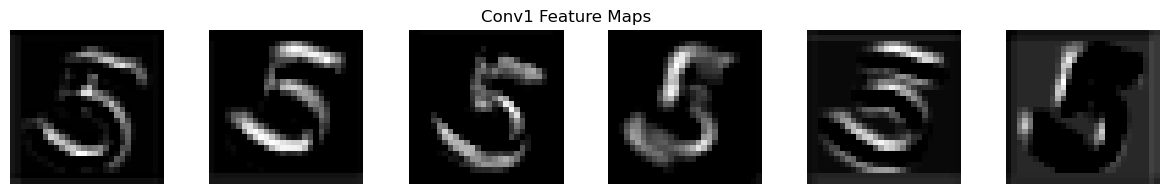

In [10]:
# Assuming `x1` is the output of `conv1` layer
plot_feature_maps(layers[0], title="Conv1 Feature Maps")

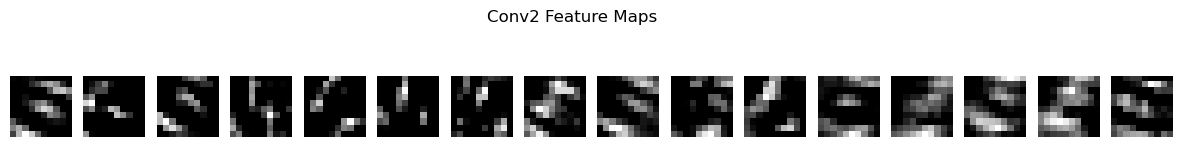

In [11]:
plot_feature_maps(layers[1], title="Conv2 Feature Maps")

## Training

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = LeNet().to(device)

In [13]:
def calculate_acc(logits, labels):
    """
    Given logits and correct labels:
    Return number of corrections and accuracy
    """
    pred = logits.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).sum().detach().cpu().item()
    return correct, 100 * correct / len(inputs)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [15]:

live_losses = []
live_accs = []

epoch_describer = tqdm(range(5), desc=f"Epoch {1}", ncols=100)

training_losses = []
training_accs = []
validation_losses = []
validation_accs = []
layer_outputs = []
    
for epoch in epoch_describer:
    
    training_loss = 0.0
    training_corr = 0.0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        correct, accuracy = calculate_acc(outputs, labels)
        
        training_corr += correct
        training_loss += loss.detach().cpu().item()
        
        live_losses.append(loss.detach().cpu().item())
        live_accs.append(accuracy)
        if len(live_losses) > 100:
            live_losses.pop(0)
            live_accs.pop(0)
            
        # update 
        epoch_describer.\
        set_description(f"Epoch {epoch+1} [loss:{np.mean(live_losses):.2f}, acc:{np.mean(live_accs):.2f}]")
        
    # record training data per epoch
    training_losses.append(training_loss / len(train_dataloader))
    training_accs.append(training_corr / len(train_dataloader.dataset))
        
    # validate the result
    valid_loss = 0.0
    valid_corr = 0.0
    
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            correct, accuracy = calculate_acc(outputs, labels)
            
            valid_loss += loss.detach().cpu().item()
            valid_corr += correct
    # record layers ouput for each epoch        
    with torch.no_grad():
        layer_outputs.append(model(random_image.to(device), return_intermediate=True))
       
    validation_losses.append(valid_loss / len(test_dataloader))
    validation_accs.append(valid_corr / len(test_dataloader.dataset))


Epoch 5 [loss:0.29, acc:91.61]: 100%|█████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]


In [16]:
#layer_ouputs (epoch)*(layer)*(output) 
layer_outputs[0][0].shape

torch.Size([6, 28, 28])

In [17]:
len(layer_outputs)

5

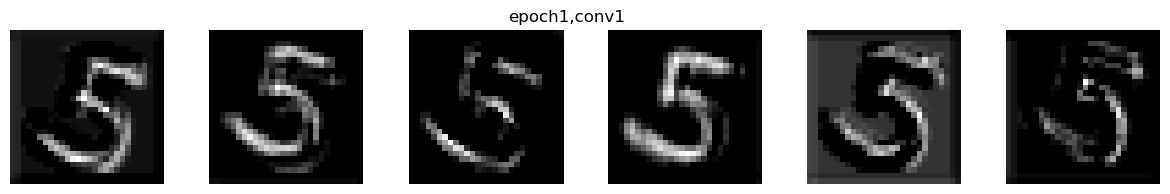

In [18]:
plot_feature_maps(layer_outputs[0][0],"epoch1,conv1")

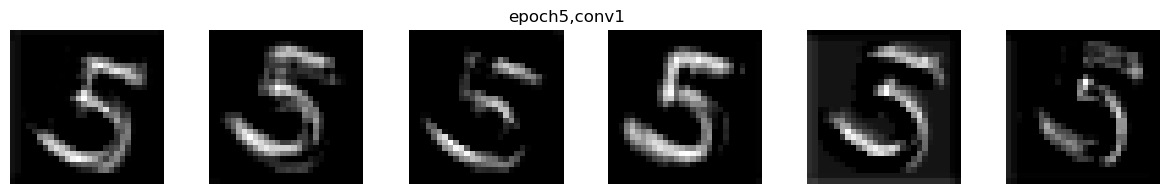

In [19]:
plot_feature_maps(layer_outputs[4][0],"epoch5,conv1")

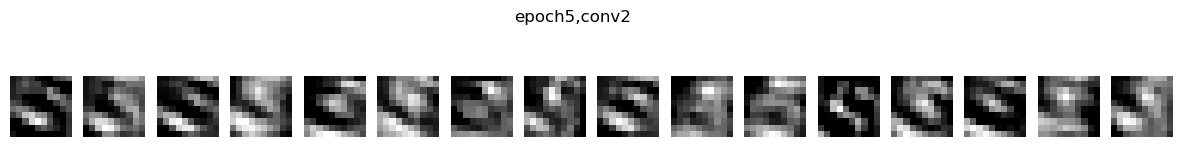

In [20]:
plot_feature_maps(layer_outputs[4][1],"epoch5,conv2")

# Section 2: Analysis wTw of Resnet 18

In [21]:
import os
import json
import sys
import copy

root_dir = os.path.join(os.getcwd(), "..")
sys.path.append(root_dir)

from src.experiment.Experiment import Experiment

In [22]:
path = "../config/resnet18_config.json"
with open(path) as json_file:
    config = json.load(json_file)
config['data']['path'] = "../data"
config['training']['epochs'] = 1
config['optimizer']['lr'] = 1e-7

In [23]:
exp = Experiment(config = config)

Using device cuda
Creating dataloaders...
Dataloaders created
Creating model...
Model resnet18 created


In [24]:
print("Test Acc:", exp.test_model()[1])

Test Acc: 9.82


In [25]:
model_epoch0 = copy.deepcopy(exp.get_model())
results1 = exp.run(run_epochs = 1)
print("Test Acc:", exp.test_model()[1])

		running experiment


Train (loss=2.269, acc=23.372): 100%|█████████████████████████████████| 1/1 [00:20<00:00, 20.27s/it]


Test Acc: 11.35


In [26]:
model_epoch1 = copy.deepcopy(exp.get_model())
results2 = exp.run(run_epochs = 1)
print("Test Acc:", exp.test_model()[1])

		running experiment


Train (loss=1.297, acc=69.103): 100%|█████████████████████████████████| 1/1 [00:20<00:00, 20.34s/it]


Test Acc: 87.38


In [27]:
model_epoch2 = copy.deepcopy(exp.get_model())
results3 = exp.run(run_epochs = 1)
print("Test Acc:", exp.test_model()[1])

		running experiment


Train (loss=0.414, acc=92.091): 100%|█████████████████████████████████| 1/1 [00:20<00:00, 20.40s/it]


Test Acc: 93.35


In [28]:
model_epoch3 = copy.deepcopy(exp.get_model())

## Analyze wTw

In [29]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
weight_0 = model_epoch0.conv1.weight.data.detach().cpu().numpy()
weight_1 = model_epoch1.conv1.weight.data.detach().cpu().numpy()
weight_2 = model_epoch2.conv1.weight.data.detach().cpu().numpy()
weight_3 = model_epoch3.conv1.weight.data.detach().cpu().numpy()

weight_0 = weight_0.reshape((64, 9))
weight_1 = weight_1.reshape((64, 9))
weight_2 = weight_2.reshape((64, 9))
weight_3 = weight_3.reshape((64, 9))

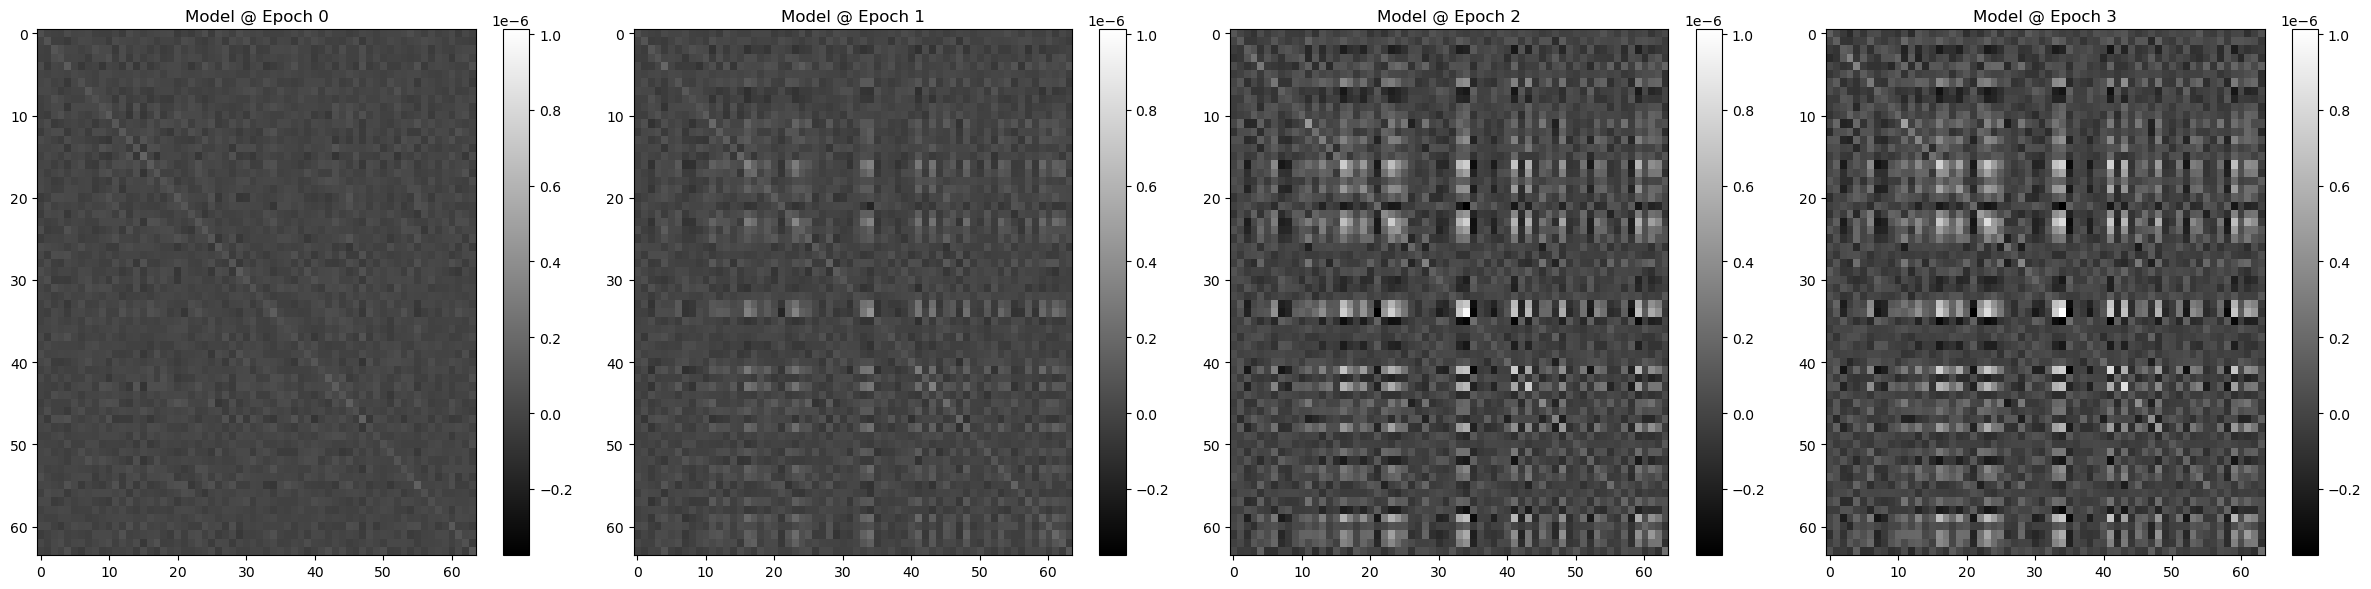

In [31]:
# Find global min and max values for consistent color scaling
all_weights = [weight_0 @ weight_0.T, weight_1 @ weight_1.T, weight_2 @ weight_2.T, weight_3 @ weight_3.T]
vmin = min([np.min(w) for w in all_weights])
vmax = max([np.max(w) for w in all_weights])

fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Create a figure and a 1x4 grid of subplots

# First subplot
im = axes[0].imshow(all_weights[0], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[0])
axes[0].title.set_text('Model @ Epoch 0')

# Second subplot
im = axes[1].imshow(all_weights[1], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[1])
axes[1].title.set_text('Model @ Epoch 1')

# Third subplot
im = axes[2].imshow(all_weights[2], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[2])
axes[2].title.set_text('Model @ Epoch 2')

# Fourth subplot
im = axes[3].imshow(all_weights[3], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[3])
axes[3].title.set_text('Model @ Epoch 3')

plt.tight_layout()
plt.show()